# Transfer Learning with Pretrained CNN

## 1. Setup & Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

## 2. Load Small Cats vs Dogs Dataset

We'll use `tf.keras.utils.get_file` to download a small filtered version of the famous dataset.

In [2]:
import os
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
base_dir = os.path.join(zip_path, 'PetImages')

# Remove corrupted images (common issue)
import os
from PIL import Image

def clean_images(directory):
    for subdir in ['Cat', 'Dog']:
        path = os.path.join(directory, subdir)
        for fname in os.listdir(path):
            fpath = os.path.join(path, fname)
            try:
                img = Image.open(fpath)
                img.verify()
            except:
                os.remove(fpath)

clean_images(base_dir)

824887076/824887076 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## 3. Preprocess & Create Data Generators

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Only rescaling for pretrained model
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## 4. Load Pretrained ResNet50 (Freeze Base)

In [4]:
# Load ResNet50 without top, pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# input shape is 244 x 244 x 3 because that's what ImageNet is trained for

# Freeze all layers
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 5. Train (Only Top Layers)

In [5]:
# make sure to switch to T4 GPU before training

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.5511 - loss: 0.6979 - val_accuracy: 0.6142 - val_loss: 0.6511
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - accuracy: 0.6013 - loss: 0.6581 - val_accuracy: 0.6242 - val_loss: 0.6448
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.6159 - loss: 0.6518 - val_accuracy: 0.6383 - val_loss: 0.6406
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.6191 - loss: 0.6481 - val_accuracy: 0.6220 - val_loss: 0.6404
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.6175 - loss: 0.6509 - val_accuracy: 0.6425 - val_loss: 0.6343


## 6. Unfreeze Some Layers & Fine-tune

In [6]:
# Unfreeze last 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 137ms/step - accuracy: 0.6420 - loss: 0.8020 - val_accuracy: 0.7389 - val_loss: 0.5163
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.7465 - loss: 0.5244 - val_accuracy: 0.7759 - val_loss: 0.4814
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.7781 - loss: 0.4715 - val_accuracy: 0.7321 - val_loss: 0.5461
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8005 - loss: 0.4307 - val_accuracy: 0.7749 - val_loss: 0.4672
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.8238 - loss: 0.3892 - val_accuracy: 0.7693 - val_loss: 0.4707


## 7. Plot Results

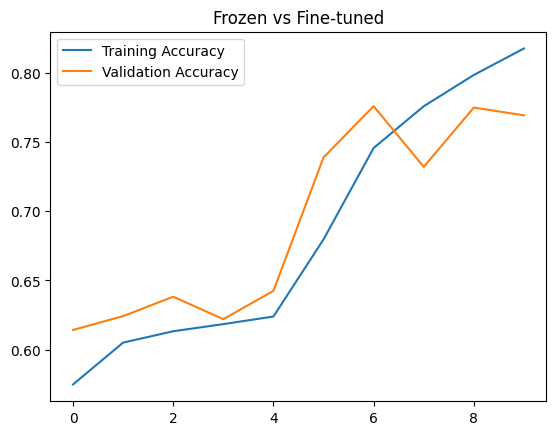

In [7]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Frozen vs Fine-tuned')
plt.legend()
plt.show()

## Done!  
- Used **ResNet50**  
- **Froze** base → trained head  
- **Unfroze** last 20 layers → fine-tuned